In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
df = pd.read_csv('Admission_Predict.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.500000,4.500000,9.650000,1,1
1,2,324,107,4,4.000000,4.500000,8.870000,1,1
2,3,316,104,3,3.000000,3.500000,8.000000,1,0
3,4,322,110,3,3.500000,2.500000,8.670000,1,1
4,5,314,103,2,2.000000,3.000000,8.210000,0,0


In [4]:
## checking the shape
df.shape

(400, 9)

In [5]:
## checking datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 28.2 KB


### according to the data definition, Research is a categorical variable, which is wrongly interpreted as 'int64', so we will convert these variables data type to 'object'.

In [6]:
df['Research'] = df['Research'].astype(object)

In [7]:
df.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research              object
Chance of Admit        int64
dtype: object

In [9]:
## removing insignificant variables:
df = df.drop('Serial No.',axis=1)

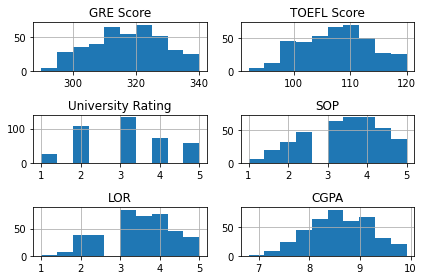

In [10]:
## distribution of the variables.
df.drop('Chance of Admit',axis=1).hist()
plt.tight_layout()

In [11]:
df.skew()

GRE Score           -0.062893
TOEFL Score          0.057216
University Rating    0.171260
SOP                 -0.275761
LOR                 -0.106991
CGPA                -0.065991
Research            -0.191582
Chance of Admit      0.201765
dtype: float64

In [13]:
## distribution of the target variable:
df['Chance of Admit'].value_counts(normalize=True)*100

0   55.000000
1   45.000000
Name: Chance of Admit, dtype: float64

<AxesSubplot:xlabel='Chance of Admit', ylabel='count'>

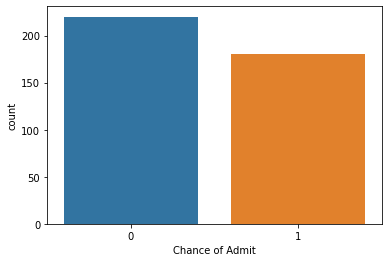

In [14]:
sns.countplot(df['Chance of Admit'])

## The dataset is not imbalanced.

In [15]:
## checking for the null values.
df.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [19]:
## dummy encode the categorical variables.
df = pd.get_dummies(data=df, drop_first=True)
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit,Research_1
0,337,118,4,4.500000,4.500000,9.650000,1,1
1,324,107,4,4.000000,4.500000,8.870000,1,1
2,316,104,3,3.000000,3.500000,8.000000,0,1
3,322,110,3,3.500000,2.500000,8.670000,1,1
4,314,103,2,2.000000,3.000000,8.210000,0,0


## Splitting the dataset.

- Before applying various classification techniques to predict the admission status of the student, let us split the dataset in train and test set.

In [21]:
X = df.drop('Chance of Admit',axis=1)
y = df['Chance of Admit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (320, 7)
y_train (320,)
X_test (80, 7)
y_test (80,)


## creating function to calculate the metrics for the test dataset:

In [22]:
def get_classification_report(model):
    y_pred = model.predict(X_test)
    return (classification_report(y_test, y_pred))

## creating function to plot the Confusion matrix:

In [31]:
def plot_confusion_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cont_mat = pd.DataFrame(cm, index=['actual:0','actual:1'], columns=['Predicted:0','Predicted:1'])
    sns.heatmap(cont_mat, annot=True, fmt='d', cmap=ListedColormap(['yellow']), cbar=False,
               linewidths=0.1, annot_kws={'size':25})

## creating function to plot the roc-auc Curve:

In [60]:
def plot_roc_curve(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr,tpr,threshold = roc_curve(y_test,y_pred_prob)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.text(x=0.6,y=0.3,s=('AUC-Score: ',round(roc_auc_score(y_test,y_pred_prob),4)))
    plt.grid(True)

# Boosting Methods.

- The **Ensemble technique considers multiple models for predicting the results.**
- **Bagging and Boosting** are two of the types of ensembles.
- The **bagging methods construct the multiple models in parallel** whereas, the **boosting methods construct the models sequentially.**
- Earlier, we have studied one of the **bagging (bootstrap aggregating) technique i.e. Random Forest.**
- The boosting method fits multiple weak classifiers to create a strong classifier. In this method, the model tries to correct the errors in the previous model. In this section, we learn some of the boosting methods such as **AdaBoost, Gradient Boosting and XGBoost.**

# AdaBoost.

- Let us build the AdaBoost classifier with decision trees. 
- `The model creates several stumps (decision tree with only a single decision node and two leaf nodes) on the train set and predicts the class based on these weak learners (stumps).`
- `For the first model, it assigns equal weights to each sample.` 
- `It assigns the higher weight for the wrongly predicted samples and lower weight for the correctly predicted samples. This method continues till all the observations are correctly classified or the predefined number of stumps is created.`

#### building an Adaboost model on a training dataset.

In [29]:
adaboost = AdaBoostClassifier(n_estimators=40, random_state=10)

ada_model = adaboost.fit(X_train, y_train)

#### plotting the confusion matrix by calling the function.

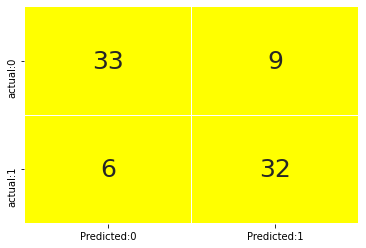

In [33]:
plot_confusion_matrix(ada_model)

In [36]:
print(get_classification_report(ada_model))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        42
           1       0.78      0.84      0.81        38

    accuracy                           0.81        80
   macro avg       0.81      0.81      0.81        80
weighted avg       0.81      0.81      0.81        80



#### Plotting roc-curve by calling the fucntion.

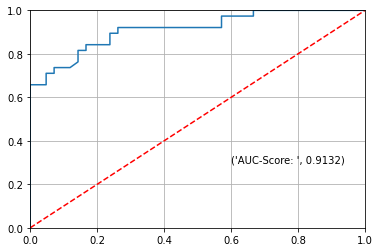

In [54]:
plot_roc_curve(ada_model)

### Interpretation: 
- The red dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
- From the above plot, we can see that the AdaBoost model is away from the dotted line; with the AUC score 0.9132.

# Gradient Boosting.

- This method optimizes the differentiable loss function by building the number of weak learners (decision trees) sequentially. 
- It considers the residuals from the previous model and fits the next model to the residuals. The algorithm uses a gradient descent method to minimize the error.

#### Build a gradient boosting model on a training dataset

In [62]:
gboost_model = GradientBoostingClassifier(n_estimators=150, max_depth=10, random_state=10)

gboost_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=150, random_state=10)

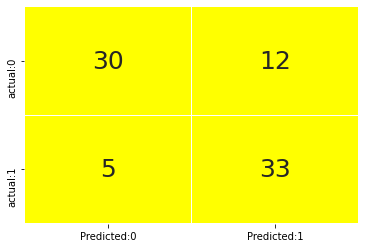

In [63]:
plot_confusion_matrix(gboost_model)

In [64]:
print(get_classification_report(gboost_model))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78        42
           1       0.73      0.87      0.80        38

    accuracy                           0.79        80
   macro avg       0.80      0.79      0.79        80
weighted avg       0.80      0.79      0.79        80



### Interpretation: The classification report shows that the model is 79% accurate. Also, the sensitivity and specificity are equal

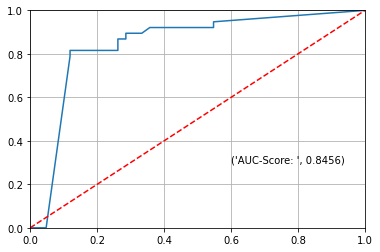

In [65]:
plot_roc_curve(gboost_model)

## Interpretation: 
- The red dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
- From the above plot, we can see that the gradient boosting model is away from the dotted line; with the AUC score 0.8954

# XG Boost.

- `XGBoost (extreme gradient boost) is an alternative form of gradient boosting method.`
- This method generally considers the initial prediction as 0.5 and build the decision tree to predict the residuals. 
- `It considers the regularization parameter to avoid overfitting.`

In [83]:
conda install py-xgboost

Solving environment: ...working... done


Note: you may need to restart the kernel to use updated packages.## Package Plan ##

  environment location: C:\Users\vikas\anaconda3


  added / updated specs:
    - py-xgboost


The following packages will be UPDATED:

  conda              conda-forge::conda-4.10.1-py38haa244f~ --> pkgs/main::conda-4.10.1-py38haa95532_1


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [84]:
from xgboost import XGBClassifier

In [92]:
xgb_model = XGBClassifier(max_depth=10, gamma=1, eval_metric='mlogloss')#######################################################

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

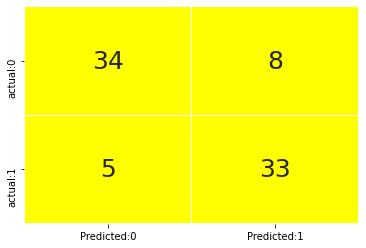

In [93]:
plot_confusion_matrix(xgb_model)

In [94]:
print(get_classification_report(xgb_model))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        42
           1       0.80      0.87      0.84        38

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



### Interpretation: The above output shows that the f1-score and accuracy of the model is 0.84

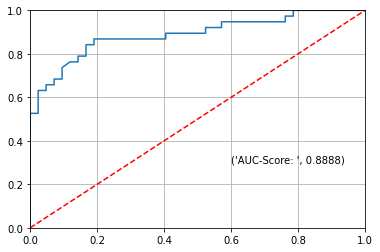

In [95]:
plot_roc_curve(xgb_model)

### Interpreatation:
- The red dotted line indicates the roc-curve of a purely random classifier, a good classifier stays as far as away from that line as possible(toward top left corner).
- From the above plot we can see that the XGBoost model is away from the dotted line, with the AUC-Score of 0.88.

## Tune the Hyperparameters (GridSearchCV)
- Let us tune the hyperparameters to obtain the optimal values for the XGBoost model.

# SET EVAL METRIC INSIDE THE XGBOOST CLASSIFIER.

In [97]:
tuned_params = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6],
               'max_depth':range(3,10),
               'gamma':[0,1,2,3,4]}

xgb_model = XGBClassifier(eval_metric='mlogloss') ############################

xgb_gsearch = GridSearchCV(estimator=xgb_model, param_grid=tuned_params,
                          cv=3, scoring='roc_auc')

xgb_gsearch_model = xgb_gsearch.fit(X_train, y_train)

In [98]:
xgb_gsearch_model.best_params_

{'gamma': 4, 'learning_rate': 0.3, 'max_depth': 4}

## Build the model using the tuned hyperparameters.

In [100]:
xgb_grid_best = XGBClassifier(learning_rate=0.3, gamma=4, max_depth=4,
                             eval_metric='mlogloss')

xgb_grid_best_model = xgb_grid_best.fit(X_train, y_train)

In [101]:
print(get_classification_report(xgb_grid_best_model))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84        42
           1       0.80      0.87      0.84        38

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



### Interpretation: 
- The above output shows that the f1-score and accuracy of the model is 0.84.

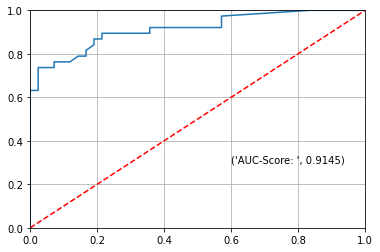

In [102]:
plot_roc_curve(xgb_grid_best_model)

### Interpretation: 
- The red dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
- From the above plot, we can see that the XGBoost model (GridSearchCV) is away from the dotted line; with the AUC score 0.9145

## Identify the Important Features using xGBoost.

In [104]:
imp_features = pd.DataFrame({'features':X_train.columns,
                            'Importance':xgb_grid_best_model.feature_importances_})

imp_features = imp_features.sort_values('Importance',ascending=False).reset_index(drop=True)

imp_features

,features,Importance
0,CGPA,0.554823
1,University Rating,0.118048
2,GRE Score,0.108890
3,LOR,0.083376
4,TOEFL Score,0.070825
5,SOP,0.064038
6,Research_1,0.000000


<AxesSubplot:xlabel='Importance', ylabel='features'>

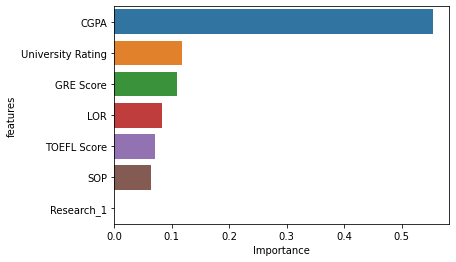

In [105]:
sns.barplot(x='Importance',y='features',data=imp_features)

### Interpretation: The above bar plot shows that, the variable CGPA is of highest importance.

# Stack Generalization.

- Stacking is a machine learning technique that takes several classification or regression models and uses their predictions as the input for the meta-classifier (final classifier) or meta-regressor (final regressor).

- `As we are using the distance-based algorithm like KNN, we scale the data before applying the stacking technique.`

### Scaling the data

In [106]:
ss = StandardScaler()

In [120]:
df_num = df.iloc[:,:6]
df_num.head(2)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA
0,337,118,4,4.500000,4.500000,9.650000
1,324,107,4,4.000000,4.500000,8.870000


In [123]:
df_dummy = df.iloc[:,6:]
df_dummy.head(2)

,Chance of Admit,Research_1
0,1,1
1,1,1


### lets scale the continous variables:

In [126]:
df_num_scaled = ss.fit_transform(df_num)

df_num_scaled = pd.DataFrame(df_num_scaled, columns=df_num.columns)

df_num_scaled.head(2)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA
0,1.762107,1.746971,0.798829,1.093864,1.167321,1.764818
1,0.627656,-0.067635,0.798829,0.596653,1.167321,0.455151


### lets concat the scaled variables and dummy variables.

In [130]:
df = pd.concat([df_num_scaled,df_dummy],axis=1)
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit,Research_1
0,1.762107,1.746971,0.798829,1.093864,1.167321,1.764818,1,1
1,0.627656,-0.067635,0.798829,0.596653,1.167321,0.455151,1,1
2,-0.070467,-0.562528,-0.076600,-0.397769,0.052933,-1.005631,0,1
3,0.453126,0.427257,-0.076600,0.099442,-1.061454,0.119339,1,1
4,-0.244998,-0.727492,-0.952029,-1.392191,-0.504260,-0.653029,0,0


In [131]:
X = df.drop('Chance of Admit',axis=1)
y = df['Chance of Admit']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (320, 7)
y_train (320,)
X_test (80, 7)
y_test (80,)


### Build the stacking classifier using the Random forest, KNN and Naive bayes as base learners (consider the hyperparameters tuned using GridSearchCV in the previous sessions)

In [133]:
base_learners = [('rf_model',RandomForestClassifier(criterion='entropy',max_depth=10,
                                                   max_features='sqrt',max_leaf_nodes=5,
                                                   min_impurity_split=2,n_estimators=50,
                                                   random_state=10)),
                ('KNN_model',KNeighborsClassifier(n_neighbors=17,metric='euclidean')),
                ('NB_model',GaussianNB())]

stack_model = StackingClassifier(estimators=base_learners,
                                 final_estimator=GaussianNB())

stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf_model',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=5,
                                                       min_impurity_split=2,
                                                       n_estimators=50,
                                                       random_state=10)),
                               ('KNN_model',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=17)),
                               ('NB_model', GaussianNB())],
                   final_estimator=GaussianNB())

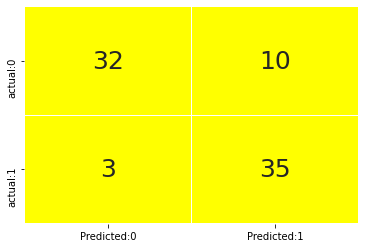

In [134]:
plot_confusion_matrix(stack_model)

In [135]:
print(get_classification_report(stack_model))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83        42
           1       0.78      0.92      0.84        38

    accuracy                           0.84        80
   macro avg       0.85      0.84      0.84        80
weighted avg       0.85      0.84      0.84        80



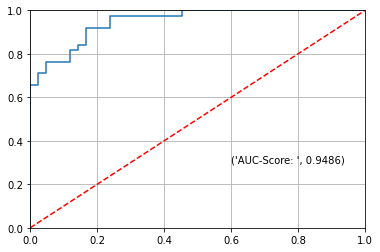

In [136]:
plot_roc_curve(stack_model)

## Interpretation: 
- The red dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
- From the above plot, we can see that the stacking model is away from the dotted line; with the AUC score 0.9492.